# Compute the Time of Emergence 

In [1]:
import os
import shutil
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pop_tools
import xpersist as xp

import dask

import util

Cannot write to data cache '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Spin up cluster

In [113]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
try:
    cluster
    client
except:
    cluster = NCARCluster()
    cluster.scale(30)
    client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.15:43113 Dashboard: https://jupyterhub.ucar.edu/dav/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load DJF dataset

In [60]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']]
ds_djf

<xarray.Dataset>
Dimensions:    (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * length     (length) float64 20.0 40.0 60.0
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 3, 1, 93, 320), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [61]:
%%time
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
    
ds_ctrl_mean

CPU times: user 5.16 s, sys: 3.17 s, total: 8.33 s
Wall time: 7.13 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
  * length    (length) float64 20.0 40.0 60.0
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 23.14 23.04 22.99 22.96
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.1035 0.1016 0.09941
    KGP       (length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

Standard deviation of anomalies

In [62]:
%%time
ds_ctrl_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_std

CPU times: user 30 s, sys: 15.6 s, total: 45.6 s
Wall time: 28.9 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
  * length    (length) float64 20.0 40.0 60.0
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.4305 0.4294 0.4313
    Chl_surf  (nlat, nlon) float64 0.0 0.0 0.0 ... 0.002909 0.003036 0.003102
    KGP       (length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

## Compute the sign of the forced trend

In [63]:
%%time
ds_trend_sign = xr.where(
    ds_djf.sel(time=slice(2091, 2100)).mean(['time', 'member_id']) >= ds_ctrl_mean, 1., -1
).compute()
ds_trend_sign    

CPU times: user 4.31 s, sys: 2.74 s, total: 7.05 s
Wall time: 6.24 s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
  * length    (length) float64 20.0 40.0 60.0
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Chl_surf  (nlat, nlon) float64 1.0 1.0 1.0 1.0 1.0 ... -1.0 -1.0 -1.0 -1.0
    KGP       (length, nlat, nlon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

## Compute the value of the threshold for ToE

In [ ]:
ds_toe_threshold = ds_ctrl_mean + 2. * ds_ctrl_std * ds_trend_sign
ds_toe_threshold

Quick plot

## Compute the time-evolving 2$\sigma$ timeseries

In [67]:
%%time
ds_2sigma = ds_djf.mean('member_id') + 2. * ds_djf_sign * ds_djf.std('member_id')
ds_2sigma = ds_2sigma.compute()
ds_2sigma

CPU times: user 1min 45s, sys: 1min 20s, total: 3min 6s
Wall time: 1min 53s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
  * length    (length) float64 20.0 40.0 60.0
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
    dz        (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
  * z_t       (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 27.12 27.05 26.99
    Chl_surf  (time, nlat, nlon) float64 0.0 0.0 0.0 ... 0.06238 0.06209 0.06176
    KGP       (time, length, nlat, nlon) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

## Identify where the 2 sigma threshold has been crossed

In [73]:
%%time
ds_x_thresh = xr.where(ds_trend_sign > 0,
               ds_2sigma > ds_toe_threshold,
               ds_2sigma < ds_toe_threshold,               
               ).compute()
ds_x_thresh

CPU times: user 83.7 ms, sys: 12.1 ms, total: 95.8 ms
Wall time: 97.7 ms


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320, time: 180, z_t: 60, z_t_150m: 15)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
  * length    (length) float64 20.0 40.0 60.0
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
    dz        (z_t) float32 1000.0 1000.0 1000.0 ... 24996.244 24998.11
  * z_t       (z_t) float32 500.0 1500.0 2500.0 ... 487508.34 512502.8 537500.0
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    SST       (nlat, nlon, time) bool False False False False ... True True True
    Chl_surf  (nlat, nlon, time) bool False False False False ... True True True
    KGP       (length, nlat, nlon, time) bool False False False ... False False

## Compute ToE

In [145]:
%%time

@dask.delayed
def assess_toe(da_x_thresh):
    if not any(da_x_thresh[:]):
        return da_x_thresh.time.data[-1]
    else:
        for l in range(len(da_x_thresh.time)):
             if all(da_x_thresh[l:]):
                return da_x_thresh.time.data[l]
        return da_x_thresh.time.data[-1]
    
ds_toe = xr.Dataset()
for v in ['SST', 'Chl_surf', 'KGP']:
    da = ds_x_thresh[v].stack(non_lateral_dims=[d for d in ds_x_thresh[v].dims if d != 'time'])
    da_toe_stack = da.isel(time=0, drop=True)

    toe_results = []
    for i in range(len(da.non_lateral_dims)):
        toe_results.append(assess_toe(da[:, i]))
    da_toe_stack.data = np.array(dask.compute(*toe_results)).astype(da.time.dtype)
    ds_toe[v] = da_toe_stack.unstack('non_lateral_dims')
ds_toe

CPU times: user 4min 39s, sys: 12.1 s, total: 4min 51s
Wall time: 5min 32s


<xarray.Dataset>
Dimensions:   (length: 3, nlat: 93, nlon: 320)
Coordinates:
    ULONG     (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 317.8 318.9 320.0
    TLONG     (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    ULAT      (nlat, nlon) float64 -78.95 -78.95 -78.95 ... -29.82 -29.82 -29.82
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TAREA     (nlat, nlon) float64 1.125e+13 1.125e+13 ... 6.346e+13 6.346e+13
    KMT       (nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... 53.0 53.0 53.0 54.0
  * nlat      (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 83 84 85 86 87 88 89 90 91 92
  * nlon      (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
  * length    (length) float64 20.0 40.0 60.0
Data variables:
    SST       (nlat, nlon) int64 2100 2100 2100 2100 ... 1984 1984 1984 1984
    Chl_surf  (nlat, nlon) int64 2100 2100 2100 2100 ... 1987 2001 2022 2022
    KGP       (length, nlat, nlon) int64 2100 2100 2100 2100 ... 2100 2100 2100

## Illustrative visualization

Did everything work?

- Dashed red lines show ±2$\sigma$ around unperturbed climate mean (dashed black)
- Heavy dashed red line shows the 2$\sigma$ value relevant as ToE threshold (depends on sign of change)
- Blue line shows the time-evolving 2$\sigma$ above (or below) the ensemble mean
- Star shows ToE: the first year where blue line is outside of red and stays out

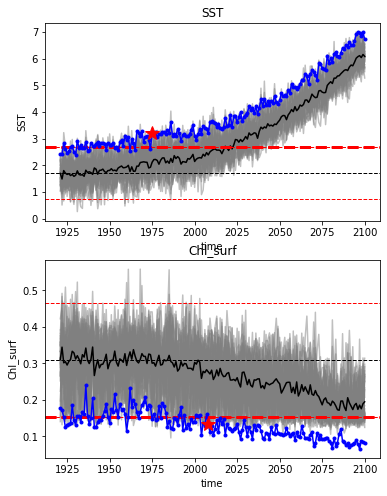

In [147]:
i = 100
j = 40
variables = [
    'SST',
    'Chl_surf',     
]

nrow = len(variables) 
ncol = 1
fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 4*nrow), squeeze=False) 

for n, v in enumerate(variables):
    ax = axs[np.unravel_index(n, axs.shape)]
    
    # plot the ensemble
    for m_id in ds_djf.member_id.values:
        ds_djf[v].isel(nlat=j, nlon=i).sel(member_id=m_id).plot(ax=ax, color='gray', alpha=0.5)

    ds_djf[v].isel(nlat=j, nlon=i).mean('member_id').plot(ax=ax, color='k')
    
    # plot the control climate ± std
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i), lw=1, color='k', linestyle='--')
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i) + 2 * ds_ctrl_std[v].isel(nlat=j, nlon=i), 
               lw=1, color='r', linestyle='--')
    ax.axhline(ds_ctrl_mean[v].isel(nlat=j, nlon=i) - 2 * ds_ctrl_std[v].isel(nlat=j, nlon=i), 
               lw=1, color='r', linestyle='--')
    
    # highlight the threshold 
    ax.axhline(ds_toe_threshold[v].isel(nlat=j, nlon=i), 
               lw=3, color='r', linestyle='--',               
              )
    
    ds_extreme[v].isel(nlat=j, nlon=i).plot(ax=ax, color='b', marker='.')
    
    ax.plot(
        ds_toe[v].isel(nlat=j, nlon=i), 
        ds_extreme[v].isel(nlat=j, nlon=i).sel(time=ds_toe[v].isel(nlat=j, nlon=i)), 
        'r*', 
        markersize=15
    )
    ax.set_title(v)

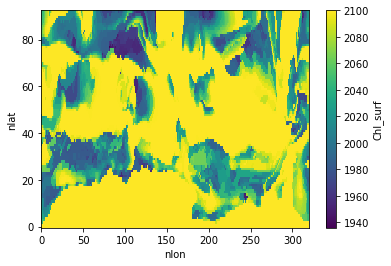

In [148]:
ds_toe.Chl_surf.plot()

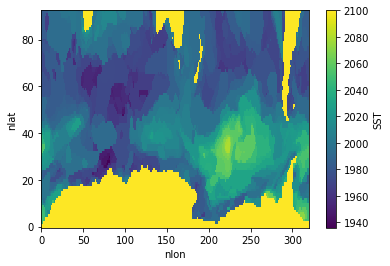

In [149]:
ds_toe.SST.plot()

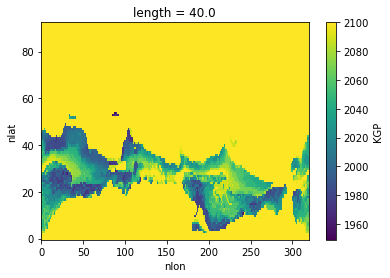

In [151]:
ds_toe.KGP.sel(length=40).plot()

In [153]:
util.write_ds_out(ds_toe, f'data/cesm-le-fields-djf-ToE-maps.zarr')

------------------------------
Writing /glade/u/home/mclong/p/krill-cesm-le/notebooks/data/cesm-le-fields-djf-ToE-maps.zarr
xarray.Dataset {
dimensions:
	length = 3 ;
	nlat = 93 ;
	nlon = 320 ;

variables:
	float64 ULONG(nlat, nlon) ;
		ULONG:long_name = array of u-grid longitudes ;
		ULONG:units = degrees_east ;
	float64 TLONG(nlat, nlon) ;
		TLONG:long_name = array of t-grid longitudes ;
		TLONG:units = degrees_east ;
	float64 ULAT(nlat, nlon) ;
		ULAT:long_name = array of u-grid latitudes ;
		ULAT:units = degrees_north ;
	float64 TLAT(nlat, nlon) ;
		TLAT:long_name = array of t-grid latitudes ;
		TLAT:units = degrees_north ;
	float64 TAREA(nlat, nlon) ;
		TAREA:long_name = area of T cells ;
		TAREA:units = centimeter^2 ;
	float64 KMT(nlat, nlon) ;
		KMT:long_name = k Index of Deepest Grid Cell on T Grid ;
	int64 nlat(nlat) ;
	int64 nlon(nlon) ;
	int64 SST(nlat, nlon) ;
	int64 Chl_surf(nlat, nlon) ;
	float64 length(length) ;
	int64 KGP(length, nlat, nlon) ;

// global attributes:
}


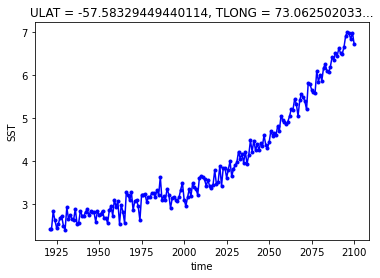

In [99]:
client.close()
cluster.close()
del client
del cluster